# S-SZD: Example of usage

In this brief notebook, we show how to use the library for minimizing arbitrary functions. 
Specifically, the library can be used both for stochastic and deterministic zeroth order minimization  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sszd import SSZD
from sszd.direction_matrices import DirectionStrategy

rnd_state = np.random.RandomState(12)

## Zeroth order minimization
We consider the deterministic zeroth order minimization problem. Given a function $f: \mathbb{R}^d \rightarrow \mathbb{R}$, we want to find
$$
x^* \in \arg\min\limits_{x \in \mathbb{R}^d} f(x)
$$
where we can access only to function values $f(x)$.

We start by defining the problem we want to solve by considering the minimization of the following synthetic function $f(x) = x^2$ with $x \in \mathbb{R}$

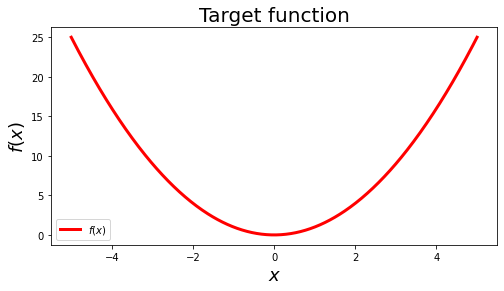

In [2]:
f = lambda x : x**2 # Target function
X = np.linspace(-5, 5, 500)
y = f(X)

_, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Target function", fontsize=20)
ax.plot(X, y, '-', c="red", lw=3, label="$f(x)$")
ax.set_xlabel("$x$", fontsize=18)
ax.set_ylabel("$f(x)$", fontsize=18)
_ = ax.legend()

Now, we instantiate the SSZD optimizer and we set its parameters

In [3]:
dir_strategy = "coordinate" # how directions are generated (in this example, coordinate directions are used)

d, l = 1, 1 # number of dimension of the space and number of directions used

# alpha : step-size schedule. The step-size must be a function that takes a parameter (timestep) and 
# returns a scalar. Constant step-sizes can be specified by defining constant functions for instance: 
# alpha = lambda k : 0.5  
alpha = lambda k : 0.4 * (k**(-1/2 -1e-7)) 

# h : discretization parameter schedule. As for the step-size, 
# it must be a function that takes as parameter the iteration and returns a scalar.
# As for step-size, constant discretization can be specified by constant functions.
h = lambda k : 1/k**2


seed = 12 # seed used to initialize the random state used to sample random matrices

dtype = np.float32 # data-type used

optimizer = SSZD(dir_strategy, d=d, l=l, alpha=alpha, h=h, seed=seed, dtype=dtype)

Then, we need to define an initial guess $x_0$ and to use the method `step` to perform an optimization step. Such method has the following signature
```
x_{k + 1}, surr = step(f, x_k, *args)
```
where 
 - `f` is the target function that takes a numpy vector and, optionally, further parameters.
 - `x_k` is the current estimate of a minimizer.
 - `x_{k + 1}` is the iterate computed.
 - `surr` is the gradient surrogate evaluated at `x_k`.

Thus, given a budget $K$, we can minimize the target function by using a for cycle and calling the `step` method as follow

In [4]:
x = 10.0 # initial guess
K = 20 # iteration budget

y_observed = [f(x)] # list of observed values

print("[--] k: 0/{}\tx: {}\ty: {}".format(K, round(x, 4), f(x)))
for k in range(1, K):
    x, grad = optimizer.step(f, x)
    y = f(x[0])
    print("[--] t: {}/{}\tx: {}\ty: {}".format(k, K, round(x[0], 4), y))
    y_observed.append(y)

# the reset method is used to reset the iteration counter used to compute 
# step-size and discretization parameter
optimizer.reset() 

[--] k: 0/20	x: 10.0	y: 100.0
[--] t: 1/20	x: 1.6	y: 2.5599999999999987
[--] t: 2/20	x: 0.7656	y: 0.5861648827985209
[--] t: 3/20	x: 0.3863	y: 0.14925249200169788
[--] t: 4/20	x: 0.2443	y: 0.059682138251008696
[--] t: 5/20	x: 0.1497	y: 0.02242228030227714
[--] t: 6/20	x: 0.1054	y: 0.011103194977424466
[--] t: 7/20	x: 0.0766	y: 0.005866904630725125
[--] t: 8/20	x: 0.0527	y: 0.002779554085219973
[--] t: 9/20	x: 0.0403	y: 0.001624775927511019
[--] t: 10/20	x: 0.0288	y: 0.000832107007246112
[--] t: 11/20	x: 0.0209	y: 0.00043645704147344573
[--] t: 12/20	x: 0.0169	y: 0.0002845541490233141
[--] t: 13/20	x: 0.0138	y: 0.0001899531118072654
[--] t: 14/20	x: 0.0114	y: 0.00012952692551631114
[--] t: 15/20	x: 0.0086	y: 7.346415038264977e-05
[--] t: 16/20	x: 0.0072	y: 5.252660136277783e-05
[--] t: 17/20	x: 0.0062	y: 3.815517315666963e-05
[--] t: 18/20	x: 0.0047	y: 2.229023413640923e-05
[--] t: 19/20	x: 0.0041	y: 1.6883470342240775e-05


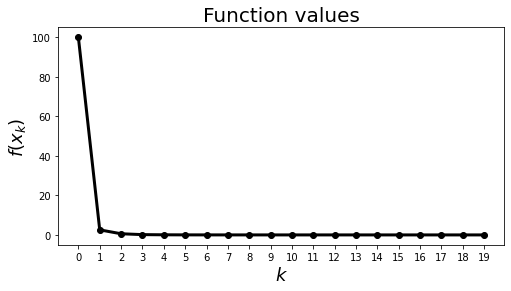

In [5]:
_, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Function values", fontsize=20)
ax.plot(range(len(y_observed)), y_observed, 'o-', lw=3, c="black", label="$f(x_k)$")
ax.set_xlabel("$k$", fontsize=18)
ax.set_ylabel("$f(x_k)$", fontsize=18)
_ = ax.set_xticks(range(len(y_observed)))

## Changing number of directions
By setting the parameter $l$, we can set the number of directions used in the direction matrices. Moreover, through the `set_l` method, you can change the number of directions during the optimization process

In [6]:
def target_function(x):
    return np.sum([x[i]**2 for i in range(x.shape[0])])

d = 5 # number of dimensions
l = 3 # number of direction

alpha = lambda k : 0.4 * (k**(-1/2 - 1e-10))
h = lambda k : 1/k**2
seed = 12
dtype = np.float32

optimizer = SSZD(dir_strategy="spherical", d=d, l=l, alpha=alpha, h=h, seed=seed, dtype=dtype)

In [7]:
x = np.array([10.0 for _ in range(d)]).reshape(-1)
y = target_function(x)

print("[--] k: 0/{}\tx: {}\ty: {}".format(K, x, y))
y_observed = [y]

for k in range(1, K):
    x, grad = optimizer.step(target_function, x)
    y = target_function(x)
    print("[--] t: {}/{}\tx: {}\ty: {}".format(k, K, x, y))
    # we can reduce/increase the number of directions during the optimization process
    # in order to reduce the time cost (decreasing l) or 
    # increase the accuracy of the gradient approximation (increasing l)
    if k > 10 and k < 15: 
        optimizer.set_l(l // 2)
    elif k > 15:
        optimizer.set_l(d)
    y_observed.append(y)

optimizer.reset() 

[--] k: 0/20	x: [10. 10. 10. 10. 10.]	y: 500.0
[--] t: 1/20	x: [-3.97530738  4.39077943 -7.70471613 -1.41255151  1.13383748]	y: 97.72555266202806
[--] t: 2/20	x: [-1.67335507  2.19710143 -8.39043144 -0.40493064 -1.16307208]	y: 79.54341712465319
[--] t: 3/20	x: [-1.75421058  4.23565244 -4.65741453  1.42879892 -1.07768799]	y: 45.912394169415556
[--] t: 4/20	x: [-1.18222537  2.30135248 -1.174871    1.77908844 -1.36866488]	y: 13.11260115919118
[--] t: 5/20	x: [-1.25097517  1.09388224 -1.07817163  0.42508853 -1.00770025]	y: 5.120131349906223
[--] t: 6/20	x: [-0.74974181  0.69844473 -0.79506526  0.09906822 -0.19584088]	y: 1.7302347694943294
[--] t: 7/20	x: [-0.49678683  0.29172779 -0.44833881  0.22706073 -0.24345611]	y: 0.643737397698786
[--] t: 8/20	x: [-0.33261458  0.14658903 -0.45790061  0.12767938 -0.29996408]	y: 0.44807424317493233
[--] t: 9/20	x: [-0.26702553  0.01498807 -0.41657697  0.17515202 -0.1781145 ]	y: 0.30746665601311823
[--] t: 10/20	x: [-0.28063748 -0.07669122 -0.35895828  0

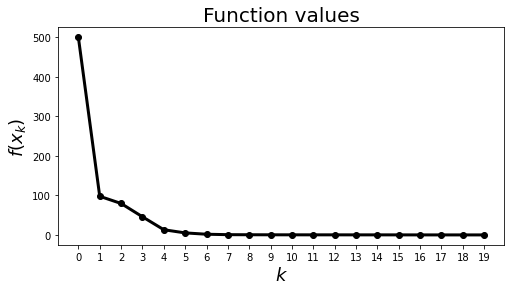

In [8]:
_, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Function values", fontsize=20)
ax.plot(range(len(y_observed)), y_observed, 'o-', lw=3, c="black", label="$f(x_k)$")
ax.set_xlabel("$k$", fontsize=18)
ax.set_ylabel("$f(x_k)$", fontsize=18)
_ = ax.set_xticks(range(len(y_observed)))

## Including stochastic information (S-SZD)
In many scenarios, the information of exact function values is not accessible. In such cases, we can access only to stochastic function values. Formally, we want to solve the stochastic zeroth order optimization problem i.e. we want to find
$$
x^* \in \arg\min\limits_{x \in \mathbb{R}^d} f(x) := \mathbb{E}_Z [F(x, Z)]
$$
where we can access only to stochastic function values $F(x, z)$ where $z$ is a realization of $Z$. A common example is the Empirical Risk minimization:
$$
f(x) = \sum\limits_{i = 1}^n F(x, z_i)
$$
where $z_i$ are data samples, $x$ are parameter configuration and $F$ is a loss function. In SSZD, the stochastic information can be included as further parameter of method `step`.

In this notebook, we consider to minimize the following function:
$$
\min\limits_{x \in \mathbb{R}^d} f(x) = \| A x \|^2
$$
where $A \in \mathbb{R}^{d \times d}$ is a random matrix. At every iteration, a random row of $A$ is observed. 

In [9]:
d = 10
l = 5
K = 20
A = rnd_state.rand(d, d)

def target_function(x, idx):
    return np.square(np.linalg.norm(A[idx].dot(x)))

alpha = lambda k : 1e-1 * (k**(-1/2))
h = lambda k : 1/k**2
seed = 12
dtype = np.float32


optimizer = SSZD(dir_strategy, d=d, l=l, alpha=alpha, h=h, seed=seed, dtype=dtype)

In [10]:
x = np.array([10.0 for _ in range(d)]).reshape(-1)
y = np.square(np.linalg.norm(A.dot(x)))

y_observed = [y]
F_observed = [target_function(x, 0)]

for k in range(1, K):
    z = rnd_state.randint(0, d)
    # the stochastic information z can be included as third parameter of step function
    x, grad = optimizer.step(target_function, x, z)
    y = target_function(x, z)
    y_observed.append(np.square(np.linalg.norm(A.dot(x))))
    F_observed.append(y)

optimizer.reset() 

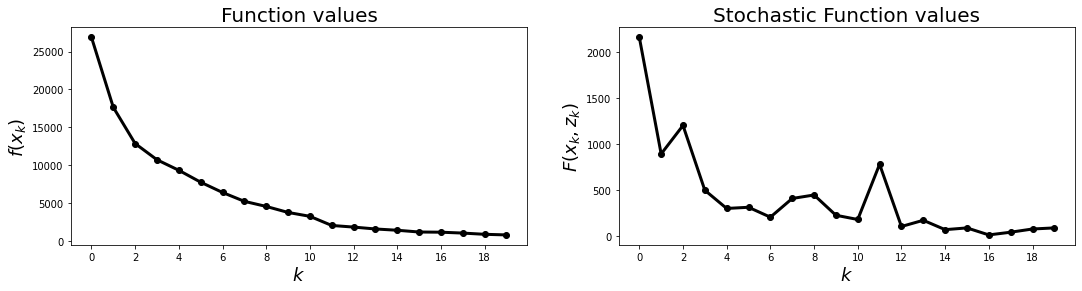

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
ax1.set_title("Function values", fontsize=20)
ax1.plot(range(len(y_observed)), y_observed, 'o-', lw=3, c="black", label="$f(x_k)$")
ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
_ = ax1.set_xticks(range(0, len(y_observed), 2))

ax2.set_title("Stochastic Function values", fontsize=20)
ax2.plot(range(len(F_observed)), F_observed, 'o-', lw=3, c="black", label="$F(x_k, z_k)$")
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$F(x_k, z_k)$", fontsize=18)
_ = ax2.set_xticks(range(0, len(F_observed), 2))

## Adding bounds
We can include bounds constraint in order to guarantee that every function evaluation will be performed in a subset of $\mathbb{R}^d$. Specifically, we would like to solve the following zeroth order optimization problem
$$
x^* \in \arg\min\limits_{x \in X} f(x)
$$
where $X \subseteq \mathbb{R}^d$ (obviously the same can be applied to the stochastic version of the problem).

To include bounds constraint, we just have to pass a numpy array to the argument `bounds` of class `SSZD`. Such numpy array must have a shape of $(d, 2)$ where $d$ is the dimension of the input space. Specifically, this numpy array will have the following structure
```
bounds = np.array([
    [lower_1, upper_1],
    [lower_2, upper_2],
    ...
    [lower_d, upper_d]
])
```
where `lower_i` and `upper_i` are the lower and upper bounds for the i-th entry of input vectors respectively. If we want add bound constraints only to some dimensions, we can use `-np.inf` and `np.inf` as lower and upper bounds respectively to represent unbounded dimensions (such values can be used also to avoid to specify some lower or upper bounds).

In [24]:
d = 10
l = 10
K = 10

def target_function(x):
    return np.sum([x[i]**2  for i in range(x.shape[0])])

alpha = lambda k : 0.5 * (k**(-1/2))
h = lambda k : 1/k**2
seed = 12
dtype = np.float32

# bounds must be specified through a d x 2 numpy array where every row represent lower and upper bounds 
# for that dimension i.e.
# bounds = [[lower_1, upper_1], [lower_2, upper_2], ..., [lower_d, upper_d]]

bounds = np.array([[-2, 2] for _ in range(d)])

optimizer = SSZD(dir_strategy, d=d, l=l, alpha=alpha, h=h, seed=seed, dtype=dtype, bounds=bounds)


x = np.array([1.0 for _ in range(d)]).reshape(-1)
y = target_function(x)
y_observed = [y]

for k in range(1, K):
    x, grad = optimizer.step(target_function, x)
    y = target_function(x)
    y_observed.append(y)

optimizer.reset() 

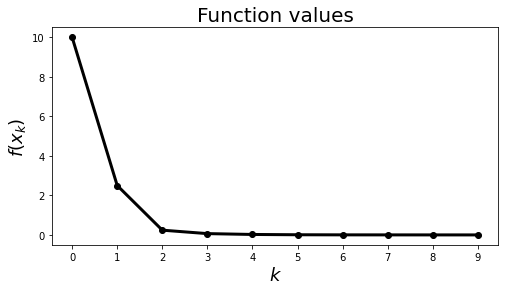

In [25]:
_, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Function values", fontsize=20)
ax.plot(range(len(y_observed)), y_observed, 'o-', lw=3, c="black", label="$f(x_k)$")
ax.set_xlabel("$k$", fontsize=18)
ax.set_ylabel("$f(x_k)$", fontsize=18)
_ = ax.set_xticks(range(len(y_observed)))